In [1]:
#| include: false
!pip install -Uqq fastcore fastai albumentations tqdm timm wandb

     |████████████████████████████████| 56 kB 1.7 MB/s 
     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 102 kB 41.9 MB/s 
     |████████████████████████████████| 376 kB 46.3 MB/s 
     |████████████████████████████████| 1.7 MB 43.9 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 45.8 MB/s 
     |████████████████████████████████| 139 kB 48.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## References and Important Links



*   Practical Deep Learning for Coders - [Lesson 5](https://colab.research.google.com/github/fastai/fastbook/blob/master/05_pet_breeds.ipynb)
*   Practical Deep Learning for Coders - [Lesson 15](https://colab.research.google.com/github/fastai/fastbook/blob/master/15_arch_details.ipynb)
*   Transfer Learning in fast.ai [forum post](https://forums.fast.ai/t/transfer-learning-in-fast-ai-how-does-the-magic-work/55620/6)
*   [Jeremy Howard talking about Transfer Learning](https://www.youtube.com/watch?v=Bi7f1JSSlh8)
*   [Andrew Ng's DeepLearningAi video about Transfer Learning](https://www.youtube.com/watch?v=yofjFQddwHE)



## Imports

In [2]:
#| code-fold: true
#| code-summary: "Imports"
import os
import random
import urllib
import urllib.request
import shutil
from glob import glob
from PIL import Image
import cv2
from collections import defaultdict


import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder

from fastcore.all import *

import wandb

In [3]:
#| include: false
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [4]:
#| include: false
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Utility Functions

Defining useful stuff we use in this Notebook:

In [5]:
#| code-fold: true
#| code-summary: "Some utility functions for this notebook"

# Data Handling stuff
def get_data(URL, FILE, FOLDER):
  # This is a function that downloads and extracts the data
  # then returns a pathlib object containing the location of the data

  # Downloading
  if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving it as {FILE}')
    print('-'*120)
    urllib.request.urlretrieve(URL, FILE)
    print('Finished Downloading')
  else:
    print(f'{FILE} already exists')
  
  # Extracting
  print('\n')
  print(f'Extracting Files into {FOLDER}')
  shutil.unpack_archive(FILE, FOLDER)
  return Path(FOLDER)

def get_loaders(bs):
  trainloader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2,
                           pin_memory=True)
  valoader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=2,
                           pin_memory=True)
  return trainloader, valoader


# Training Helper Functions
def calculate_accuracy(preds, target):
  correct = 0
  total = 0

  predicted = torch.argmax(preds, axis=1)
  total += target.shape[0]
  correct += int((predicted==target).sum())

  return correct / total

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                f"{metric_name}: {metric['avg']:.{self.float_precision}f}"
                for (metric_name, metric) in self.metrics.items()
            ]
        )

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)

## A Quick Note about fastai and Transfer Learning

Tranfer Learning is an important technique in making Deep Learning accessible to everyone. [fastai](https://www.fast.ai/) is a leading research company in the area of Transfer Learning (and almost all other Deep Learning areas too!). Out of the box, you get state of the art results with carefully chosen defaults and training methods after lots of research.

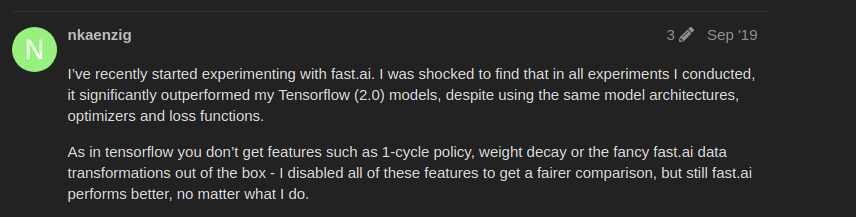

These is an example post in the [forums]() where the user tried to match the results gotten by fastai in Tensorflow. The good thing about fastai though is that they have a completely free [MOOC]() where they teach everything and how to get the good results. In this post, we will be taking insights from the course and try to implement them in PyTorch.

Some of the techniques covered here are:


*   Splitting a Pretrained Network into body and head.
*   Creating a better custom head.
*   Not freezing the BatchNorm Layer and the intuition why.
*   Freezing the body and just training the head.
*   Unfreezing the whole network and training it further to get better results.
*   Using different learning rates for the body and the head, or as it is known as, Discriminative Learning Rates.



We will be getting our pretrained models from [Ross Wightman's library](https://github.com/rwightman/pytorch-image-models) which makes availabe *almost all vision models.

We will be running our experiments on the [Imagenette](https://github.com/fastai/imagenette) dataset created by [Jeremy Howard](https://twitter.com/jeremyphoward/status/1103129618435923968?lang=en).

## Configs

We store our configurations in a dictionary for easy access and update:

In [9]:
head_lr=1e-5
body_lr = head_lr / 2.6

In [10]:
configs = dict(
    init_epochs=5,
    num_epochs=10,
    num_classes=10,
    batch_size=64,
    lr=3e-3,
    head_lr=head_lr,
    body_lr=body_lr,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dataset="Imagenette",
    architecture="resnet34")

## Getting the Data

Using a small utility function I created, we can get the data and return a Pathlib object:

In [11]:
URL = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
FILE = 'imagenette2-320.tgz'
FOLDER = 'data'

In [12]:
path = get_data(URL, FILE, FOLDER)
path.ls()

------------------------------------------------------------------------------------------------------------------------
Finished Downloading


Extracting Files into data


(#1) [Path('data/imagenette2-320')]

In [13]:
path.ls()

(#1) [Path('data/imagenette2-320')]

We can recursively get all the JPEG files from our path.

In [14]:
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('data/imagenette2-320/train/n03394916/n03394916_15417.JPEG')

In [15]:
files

(#13394) [Path('data/imagenette2-320/train/n03394916/n03394916_15417.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_41638.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_40833.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_23145.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_16274.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_34078.JPEG'),Path('data/imagenette2-320/train/n03394916/ILSVRC2012_val_00022204.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_24385.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_42289.JPEG'),Path('data/imagenette2-320/train/n03394916/n03394916_34364.JPEG')...]

We have 13394 images in total. To verify they are working correctly, we can have a look at one of the images:

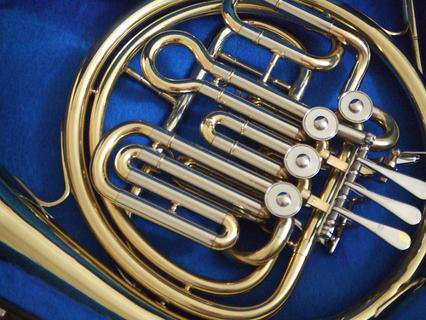

In [16]:
im = Image.open(files[2])
im

For modelling purposes, we will need the names of the images, which we can get this way:

In [17]:
files[0].parent.name

'n03394916'

We can get all the unique labels from our dataset and create a dictionary converting them to numerical format which is what our network expects:

In [18]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03394916','n03000684','n01440764','n03417042','n03425413','n02979186','n02102040','n03445777','n03028079','n03888257']

In [19]:
v2i = lbls.val2idx(); v2i

{'n01440764': 2,
 'n02102040': 6,
 'n02979186': 5,
 'n03000684': 1,
 'n03028079': 8,
 'n03394916': 0,
 'n03417042': 3,
 'n03425413': 4,
 'n03445777': 7,
 'n03888257': 9}

The following snippets of code create the Dataset for our code and creates the DataLoaders using appropriate augmentations from Albumentations:

In [20]:
class Imagenette(Dataset):
  def __init__(self, files, v2i, transform=None):
    self.files = files
    self.v2i = v2i
    self.transform = transform
  
  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, idx):
    image_filepath = self.files[idx]
    image = cv2.imread(f'{image_filepath}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.v2i[self.files[idx].parent.name]

    # transform if available
    if self.transform is not None:
      image = self.transform(image=image)["image"]
    
    return image, label

In [21]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [22]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [23]:
train_ds = Imagenette(train, v2i, train_transform)
val_ds = Imagenette(valid, v2i, val_transform)
x,y = train_ds[1000]
x.shape,y

(torch.Size([3, 128, 128]), 1)

In [24]:
len(train_ds), len(val_ds)

(9469, 3925)

In [25]:
trainloader, valoader = get_loaders(configs['batch_size'])

## Training Helper Functions

Next we define our basic training loops that we are going to use in this notebook:

Note: We are going to use Wandb's (Weights and Biaises) experiment tracking tool for logging and plotting our metrics:

In [26]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(configs['device'])
        target = target.to(configs['device'])
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
          scheduler.step()
        
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        stream.set_description(
            f"Epoch: {epoch}. Train       {metric_monitor}"
        )
    wandb.log({'Train Loss': metric_monitor.metrics['Loss']['avg'], 
               'Train Accuracy':metric_monitor.metrics['Accuracy']['avg']})

In [27]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(configs['device'])
            target = target.to(configs['device'])
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                f"Epoch: {epoch}. Validation  {metric_monitor}"
            )

        wandb.log({'Val Loss': metric_monitor.metrics['Loss']['avg'], 
                  'Val Accuracy':metric_monitor.metrics['Accuracy']['avg']})

In [29]:
def loss_func(out, targ):
    return F.cross_entropy(out, targ.long())

def get_optim(model, lr):
  return optim.AdamW(model.parameters(), lr=lr)

def get_scheduler(optimizer, max_lr, epochs):
  return optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                          steps_per_epoch=int(len(trainloader)),
                                          epochs=epochs,
                                          anneal_strategy='cos')

def fit(epochs):
  for epoch in range(1, epochs + 1):
    train(trainloader, model, loss_func, optimizer, epoch, scheduler)
    validate(valoader, model, loss_func, epoch)
    print()

## Baseline - Training from Scratch

In all Machine Learning tasks, you are better off starting with a baseline model that you can use to compare the performance of the models you are going to train.

To get some sort of baseline on how well our Transfer Learning is working, we will first get a *Resnet 34* architecture and train it from scratch without any transfer learning:

In [31]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='training from scratch'):
  config = wandb.config

  # get the model from timm
  model = timm.create_model(f'{config.architecture}', pretrained=False)
  # Change the last linear to match our number of classes
  model.fc = nn.Linear(512, config.num_classes)
  # Initialize the weights
  model.fc.apply(init_weights)
  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr, config.num_epochs+5)

  fit(config.num_epochs+5)

Epoch: 1. Train       Loss: 1.974 | Accuracy: 0.306: 100%|██████████| 148/148 [00:54<00:00,  2.70it/s]
Epoch: 1. Validation  Loss: 1.794 | Accuracy: 0.381: 100%|██████████| 62/62 [00:11<00:00,  5.34it/s]


Epoch: 2. Train       Loss: 1.736 | Accuracy: 0.399: 100%|██████████| 148/148 [00:54<00:00,  2.72it/s]
Epoch: 2. Validation  Loss: 1.855 | Accuracy: 0.392: 100%|██████████| 62/62 [00:11<00:00,  5.52it/s]


Epoch: 3. Train       Loss: 1.629 | Accuracy: 0.452: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 3. Validation  Loss: 1.904 | Accuracy: 0.423: 100%|██████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch: 4. Train       Loss: 1.532 | Accuracy: 0.490: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 4. Validation  Loss: 1.576 | Accuracy: 0.490: 100%|██████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch: 5. Train       Loss: 1.409 | Accuracy: 0.532: 100%|██████████| 148/148 [00:54<00:00,  2.72it/s]
Epoch: 5. Validation  Loss: 1.464 | Accuracy: 0.538: 100%|██████████| 62/62 [00:11<00:00,  5.18it/s]


Epoch: 6. Train       Loss: 1.329 | Accuracy: 0.560: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 6. Validation  Loss: 1.147 | Accuracy: 0.623: 100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch: 7. Train       Loss: 1.223 | Accuracy: 0.594: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 7. Validation  Loss: 1.048 | Accuracy: 0.657: 100%|██████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch: 8. Train       Loss: 1.135 | Accuracy: 0.623: 100%|██████████| 148/148 [00:54<00:00,  2.70it/s]
Epoch: 8. Validation  Loss: 1.019 | Accuracy: 0.669: 100%|██████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch: 9. Train       Loss: 1.089 | Accuracy: 0.641: 100%|██████████| 148/148 [00:55<00:00,  2.69it/s]
Epoch: 9. Validation  Loss: 1.162 | Accuracy: 0.640: 100%|██████████| 62/62 [00:11<00:00,  5.23it/s]


Epoch: 10. Train       Loss: 0.989 | Accuracy: 0.671: 100%|██████████| 148/148 [00:55<00:00,  2.65it/s]
Epoch: 10. Validation  Loss: 1.118 | Accuracy: 0.656: 100%|██████████| 62/62 [00:11<00:00,  5.44it/s]


Epoch: 11. Train       Loss: 0.940 | Accuracy: 0.693: 100%|██████████| 148/148 [00:54<00:00,  2.69it/s]
Epoch: 11. Validation  Loss: 0.883 | Accuracy: 0.716: 100%|██████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch: 12. Train       Loss: 0.874 | Accuracy: 0.711: 100%|██████████| 148/148 [00:54<00:00,  2.69it/s]
Epoch: 12. Validation  Loss: 0.796 | Accuracy: 0.741: 100%|██████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch: 13. Train       Loss: 0.828 | Accuracy: 0.729: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 13. Validation  Loss: 0.665 | Accuracy: 0.787: 100%|██████████| 62/62 [00:11<00:00,  5.32it/s]


Epoch: 14. Train       Loss: 0.781 | Accuracy: 0.743: 100%|██████████| 148/148 [00:54<00:00,  2.69it/s]
Epoch: 14. Validation  Loss: 0.648 | Accuracy: 0.790: 100%|██████████| 62/62 [00:11<00:00,  5.20it/s]


Epoch: 15. Train       Loss: 0.753 | Accuracy: 0.754: 100%|██████████| 148/148 [00:55<00:00,  2.65it/s]
Epoch: 15. Validation  Loss: 0.646 | Accuracy: 0.792: 100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Train Accuracy,▁▂▃▄▅▅▅▆▆▇▇▇███
Train Loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁▁
Val Accuracy,▁▁▂▃▄▅▆▆▅▆▇▇███
Val Loss,▇██▆▆▄▃▃▄▄▂▂▁▁▁
Train Accuracy,0.75394
Train Loss,0.75312
Val Accuracy,0.7923
Val Loss,0.64564


After 15 epochs, we get a train loss of **0.735** and a validation loss of **0.646**, which an accuracy of **79%**. This is the first baseline we are going to try and beat.

## Baseline - Basic Transfer Learning

For our second baseline, we are going to do what most tutorials on Transfer Learning do, and that is:

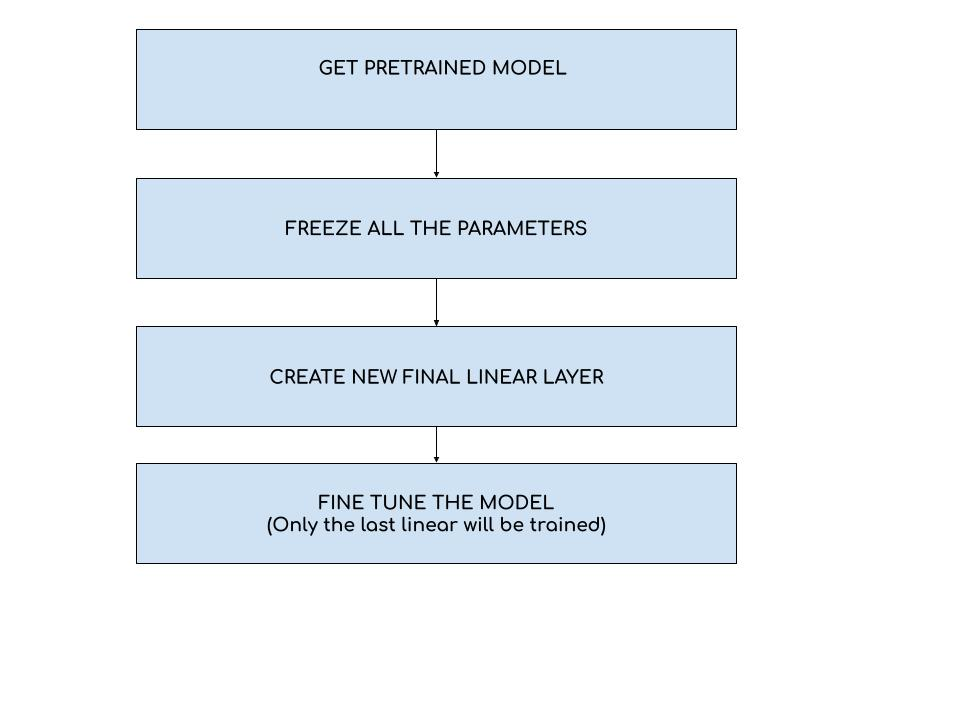


In [33]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='basic transfer learning'):
  config = wandb.config

  # get the model from timm
  model = timm.create_model(f'{config.architecture}', pretrained=True)
  # Freeze all parameters
  for param in model.parameters():
      param.requires_grad = False
  # Change the last linear to match our number of classes
  model.fc = nn.Linear(512, config.num_classes)
  # Initialize the weights
  model.fc.apply(init_weights)
  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr, config.num_epochs+5)

  fit(config.num_epochs+5)

Epoch: 1. Train       Loss: 2.645 | Accuracy: 0.213: 100%|██████████| 148/148 [00:31<00:00,  4.64it/s]
Epoch: 1. Validation  Loss: 1.493 | Accuracy: 0.520: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 2. Train       Loss: 1.218 | Accuracy: 0.603: 100%|██████████| 148/148 [00:31<00:00,  4.63it/s]
Epoch: 2. Validation  Loss: 0.550 | Accuracy: 0.834: 100%|██████████| 62/62 [00:11<00:00,  5.52it/s]


Epoch: 3. Train       Loss: 0.780 | Accuracy: 0.749: 100%|██████████| 148/148 [00:31<00:00,  4.64it/s]
Epoch: 3. Validation  Loss: 0.399 | Accuracy: 0.876: 100%|██████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch: 4. Train       Loss: 0.684 | Accuracy: 0.783: 100%|██████████| 148/148 [00:32<00:00,  4.62it/s]
Epoch: 4. Validation  Loss: 0.352 | Accuracy: 0.898: 100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch: 5. Train       Loss: 0.636 | Accuracy: 0.798: 100%|██████████| 148/148 [00:31<00:00,  4.63it/s]
Epoch: 5. Validation  Loss: 0.354 | Accuracy: 0.895: 100%|██████████| 62/62 [00:11<00:00,  5.25it/s]


Epoch: 6. Train       Loss: 0.604 | Accuracy: 0.809: 100%|██████████| 148/148 [00:31<00:00,  4.64it/s]
Epoch: 6. Validation  Loss: 0.336 | Accuracy: 0.903: 100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch: 7. Train       Loss: 0.593 | Accuracy: 0.815: 100%|██████████| 148/148 [00:32<00:00,  4.59it/s]
Epoch: 7. Validation  Loss: 0.333 | Accuracy: 0.899: 100%|██████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch: 8. Train       Loss: 0.567 | Accuracy: 0.816: 100%|██████████| 148/148 [00:32<00:00,  4.61it/s]
Epoch: 8. Validation  Loss: 0.324 | Accuracy: 0.907: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 9. Train       Loss: 0.568 | Accuracy: 0.819: 100%|██████████| 148/148 [00:32<00:00,  4.60it/s]
Epoch: 9. Validation  Loss: 0.327 | Accuracy: 0.904: 100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch: 10. Train       Loss: 0.543 | Accuracy: 0.823: 100%|██████████| 148/148 [00:32<00:00,  4.53it/s]
Epoch: 10. Validation  Loss: 0.317 | Accuracy: 0.908: 100%|██████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch: 11. Train       Loss: 0.540 | Accuracy: 0.832: 100%|██████████| 148/148 [00:32<00:00,  4.60it/s]
Epoch: 11. Validation  Loss: 0.316 | Accuracy: 0.910: 100%|██████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch: 12. Train       Loss: 0.518 | Accuracy: 0.832: 100%|██████████| 148/148 [00:32<00:00,  4.59it/s]
Epoch: 12. Validation  Loss: 0.310 | Accuracy: 0.911: 100%|██████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch: 13. Train       Loss: 0.519 | Accuracy: 0.832: 100%|██████████| 148/148 [00:32<00:00,  4.58it/s]
Epoch: 13. Validation  Loss: 0.299 | Accuracy: 0.916: 100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch: 14. Train       Loss: 0.532 | Accuracy: 0.828: 100%|██████████| 148/148 [00:31<00:00,  4.63it/s]
Epoch: 14. Validation  Loss: 0.308 | Accuracy: 0.913: 100%|██████████| 62/62 [00:11<00:00,  5.58it/s]


Epoch: 15. Train       Loss: 0.519 | Accuracy: 0.836: 100%|██████████| 148/148 [00:32<00:00,  4.56it/s]
Epoch: 15. Validation  Loss: 0.308 | Accuracy: 0.911: 100%|██████████| 62/62 [00:11<00:00,  5.56it/s]


Train Accuracy,▁▅▇▇███████████
Train Loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▇▇████████████
Val Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,0.83642
Train Loss,0.51881
Val Accuracy,0.91103
Val Loss,0.30831


For our second baseline, we get a train loss of **0.519** and a validation loss of **0.308**, which an accuracy of **91%**. This is the second baseline we are going to try and beat.

With those two Base line results, we can now start using a few tweaks and tricks to make our fine-tuning work.

## Custom Head

The first modification we are going to make to our transfer learning process is using a better custom head. 

What I mean by this is, instead of just changing the final linear classifier in our pretrained model, we are going to chop our model into two:

*   A Body which will act as our feature extractor (Already pretrained)
*   A custom head that will be our classifier.

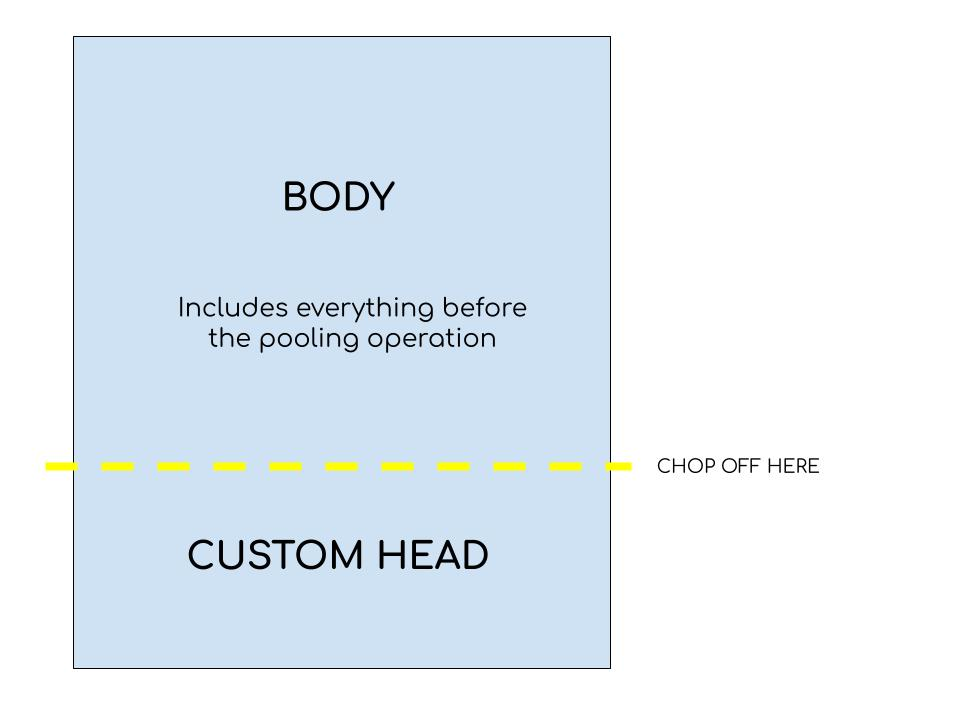



The reason we split the model right before the pooling operation is, in Deep Learning, we can fine-tune a model pretrained for classification and use it for other tasks like segmentation or object detection. Different applications might require different pooling layers or even none.

This is going to be our body of our pretrained model:

In [34]:
def make_body(model):
  layers = list((model.children()))[:-2]
  body =  nn.Sequential(*layers)

  # freeze the body
  for param in body.parameters():
    param.requires_grad = False
  
  return body

Our head is going to be a Sequential Layer that follows the following pattern:

1.   Our New Pooling operation followed by flattening the output.
2.   A Sequence of BatchNorm -> Dropout -> Linear Layer. You can add as many of these as your task at hand requires, just remember to use and activation between two such sequences.



For our task at hand, we are going to use the following configuration:

Note, the input to our BatchNorm is 512 since that's what our head receives from the body, then pools and flattens it. We won't require a ReLU for our last linear layer and its `out_features` is going to be the number of classes we have in our dataset:

In [35]:
def make_head(in_features, out_features):
  head = nn.Sequential(
      nn.AdaptiveAvgPool2d(output_size=1),
      nn.Flatten(),
      nn.BatchNorm1d(num_features=in_features),
      nn.Dropout(p=0.25),
      nn.Linear(in_features=in_features, out_features=512, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(num_features=512),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=512, out_features=out_features, bias=False)
  )
  head.apply(init_weights)
  return head


In [36]:
make_head(512, len(lbls))

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

Let us create a handy function that creates our model for us:

In [37]:
def create_model(arch):
  # get pretrained model
  model = timm.create_model(f'{arch}', pretrained=True)

  # create the body and head
  body = make_body(model)
  head = make_head(512, len(lbls))

  # fine tune the model
  model = nn.Sequential(body, head)

  return model

And then now we can do the fine-tuning:

In [38]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='transfer learning custom head'):
  config = wandb.config

  # create model
  model = create_model(config.architecture)
  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr, config.num_epochs+5)

  fit(config.num_epochs+5)

Epoch: 1. Train       Loss: 2.295 | Accuracy: 0.358: 100%|██████████| 148/148 [00:31<00:00,  4.68it/s]
Epoch: 1. Validation  Loss: 0.526 | Accuracy: 0.851: 100%|██████████| 62/62 [00:11<00:00,  5.63it/s]


Epoch: 2. Train       Loss: 1.125 | Accuracy: 0.666: 100%|██████████| 148/148 [00:31<00:00,  4.72it/s]
Epoch: 2. Validation  Loss: 0.371 | Accuracy: 0.891: 100%|██████████| 62/62 [00:11<00:00,  5.59it/s]


Epoch: 3. Train       Loss: 0.897 | Accuracy: 0.725: 100%|██████████| 148/148 [00:31<00:00,  4.67it/s]
Epoch: 3. Validation  Loss: 0.359 | Accuracy: 0.894: 100%|██████████| 62/62 [00:10<00:00,  5.71it/s]


Epoch: 4. Train       Loss: 0.822 | Accuracy: 0.743: 100%|██████████| 148/148 [00:31<00:00,  4.69it/s]
Epoch: 4. Validation  Loss: 0.331 | Accuracy: 0.899: 100%|██████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch: 5. Train       Loss: 0.770 | Accuracy: 0.758: 100%|██████████| 148/148 [00:31<00:00,  4.63it/s]
Epoch: 5. Validation  Loss: 0.318 | Accuracy: 0.904: 100%|██████████| 62/62 [00:11<00:00,  5.22it/s]


Epoch: 6. Train       Loss: 0.731 | Accuracy: 0.763: 100%|██████████| 148/148 [00:31<00:00,  4.67it/s]
Epoch: 6. Validation  Loss: 0.311 | Accuracy: 0.905: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch: 7. Train       Loss: 0.696 | Accuracy: 0.777: 100%|██████████| 148/148 [00:31<00:00,  4.65it/s]
Epoch: 7. Validation  Loss: 0.308 | Accuracy: 0.908: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 8. Train       Loss: 0.673 | Accuracy: 0.778: 100%|██████████| 148/148 [00:31<00:00,  4.69it/s]
Epoch: 8. Validation  Loss: 0.314 | Accuracy: 0.907: 100%|██████████| 62/62 [00:11<00:00,  5.63it/s]


Epoch: 9. Train       Loss: 0.667 | Accuracy: 0.786: 100%|██████████| 148/148 [00:31<00:00,  4.70it/s]
Epoch: 9. Validation  Loss: 0.300 | Accuracy: 0.907: 100%|██████████| 62/62 [00:10<00:00,  5.68it/s]


Epoch: 10. Train       Loss: 0.657 | Accuracy: 0.785: 100%|██████████| 148/148 [00:31<00:00,  4.65it/s]
Epoch: 10. Validation  Loss: 0.290 | Accuracy: 0.910: 100%|██████████| 62/62 [00:10<00:00,  5.68it/s]


Epoch: 11. Train       Loss: 0.655 | Accuracy: 0.787: 100%|██████████| 148/148 [00:31<00:00,  4.72it/s]
Epoch: 11. Validation  Loss: 0.288 | Accuracy: 0.914: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s]


Epoch: 12. Train       Loss: 0.639 | Accuracy: 0.793: 100%|██████████| 148/148 [00:31<00:00,  4.72it/s]
Epoch: 12. Validation  Loss: 0.285 | Accuracy: 0.914: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 13. Train       Loss: 0.632 | Accuracy: 0.796: 100%|██████████| 148/148 [00:31<00:00,  4.63it/s]
Epoch: 13. Validation  Loss: 0.282 | Accuracy: 0.912: 100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch: 14. Train       Loss: 0.620 | Accuracy: 0.798: 100%|██████████| 148/148 [00:32<00:00,  4.59it/s]
Epoch: 14. Validation  Loss: 0.282 | Accuracy: 0.914: 100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch: 15. Train       Loss: 0.605 | Accuracy: 0.797: 100%|██████████| 148/148 [00:32<00:00,  4.50it/s]
Epoch: 15. Validation  Loss: 0.279 | Accuracy: 0.913: 100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Train Accuracy,▁▆▇▇▇▇█████████
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▅▆▆▇▇▇▇▇▇█████
Val Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Train Accuracy,0.79691
Train Loss,0.60476
Val Accuracy,0.91305
Val Loss,0.27871


We get a train loss of **0.605** and a validation loss of **0.279**, which an accuracy of **91%**. It is a slight improvement on our fine-tuning which doesn't look like it does much, but now we have a better design of the head than just changing the classes of the last linear layer. Our custom head can be adopted to different training requirements by changing the configuration of the dropouts and batchnorms.

## Don't Freeze BatchNorm

Another tweak from fastai's MOOC is about how to handle the BatchNorm layers while fine-tuning. To understand this, we will need to go back to how `BatchNorm` works.

`BatchNorm` works differently in training vs validation. During validation, `BatchNorm` uses a running mean of the statistics calculated during training. Therefore, when we get a pretrained layer, our `BatchNorm`'s present have statistics of its previous training (commonly on Imagenet). But during our fine-tuning, we want our model to adapt to the statistics of our current training statistics, and that is why we should not freeze them.

To do this, we are just going to slightly change our `get_body` function, and not freeze BatchNorm layers while freezing the rest of the layers

In [39]:
def make_body(model):
  layers = list((model.children()))[:-2]
  body =  nn.Sequential(*layers)

  # Loop through the model and don't freeze BatchNorm
  for module in body.modules():
    if isinstance(module, torch.nn.BatchNorm2d):
      for param in module.parameters():
        param.requires_grad = True
    else:
      for param in module.parameters():
        param.requires_grad = False

  return body

Let run the experiment and see if that improves our fine-tuning:

In [40]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='transfer learning unfrozen batchnorm'):
  config = wandb.config

  # create model
  model = create_model(config.architecture)
  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr, config.num_epochs+5)

  fit(config.num_epochs+5)

Epoch: 1. Train       Loss: 2.287 | Accuracy: 0.360: 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]
Epoch: 1. Validation  Loss: 0.521 | Accuracy: 0.847: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 2. Train       Loss: 0.994 | Accuracy: 0.700: 100%|██████████| 148/148 [00:38<00:00,  3.88it/s]
Epoch: 2. Validation  Loss: 0.317 | Accuracy: 0.906: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 3. Train       Loss: 0.712 | Accuracy: 0.779: 100%|██████████| 148/148 [00:38<00:00,  3.86it/s]
Epoch: 3. Validation  Loss: 0.241 | Accuracy: 0.926: 100%|██████████| 62/62 [00:11<00:00,  5.53it/s]


Epoch: 4. Train       Loss: 0.567 | Accuracy: 0.826: 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]
Epoch: 4. Validation  Loss: 0.183 | Accuracy: 0.944: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 5. Train       Loss: 0.476 | Accuracy: 0.853: 100%|██████████| 148/148 [00:38<00:00,  3.87it/s]
Epoch: 5. Validation  Loss: 0.151 | Accuracy: 0.954: 100%|██████████| 62/62 [00:11<00:00,  5.23it/s]


Epoch: 6. Train       Loss: 0.409 | Accuracy: 0.872: 100%|██████████| 148/148 [00:37<00:00,  3.90it/s]
Epoch: 6. Validation  Loss: 0.144 | Accuracy: 0.953: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s]


Epoch: 7. Train       Loss: 0.376 | Accuracy: 0.881: 100%|██████████| 148/148 [00:37<00:00,  3.90it/s]
Epoch: 7. Validation  Loss: 0.136 | Accuracy: 0.958: 100%|██████████| 62/62 [00:11<00:00,  5.61it/s]


Epoch: 8. Train       Loss: 0.362 | Accuracy: 0.884: 100%|██████████| 148/148 [00:37<00:00,  3.93it/s]
Epoch: 8. Validation  Loss: 0.139 | Accuracy: 0.955: 100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Epoch: 9. Train       Loss: 0.342 | Accuracy: 0.892: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
Epoch: 9. Validation  Loss: 0.123 | Accuracy: 0.961: 100%|██████████| 62/62 [00:10<00:00,  5.66it/s]


Epoch: 10. Train       Loss: 0.331 | Accuracy: 0.895: 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]
Epoch: 10. Validation  Loss: 0.120 | Accuracy: 0.963: 100%|██████████| 62/62 [00:11<00:00,  5.61it/s]


Epoch: 11. Train       Loss: 0.323 | Accuracy: 0.897: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
Epoch: 11. Validation  Loss: 0.118 | Accuracy: 0.963: 100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch: 12. Train       Loss: 0.296 | Accuracy: 0.905: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
Epoch: 12. Validation  Loss: 0.112 | Accuracy: 0.964: 100%|██████████| 62/62 [00:10<00:00,  5.66it/s]


Epoch: 13. Train       Loss: 0.283 | Accuracy: 0.908: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
Epoch: 13. Validation  Loss: 0.113 | Accuracy: 0.963: 100%|██████████| 62/62 [00:10<00:00,  5.68it/s]


Epoch: 14. Train       Loss: 0.274 | Accuracy: 0.910: 100%|██████████| 148/148 [00:36<00:00,  4.01it/s]
Epoch: 14. Validation  Loss: 0.114 | Accuracy: 0.964: 100%|██████████| 62/62 [00:10<00:00,  5.75it/s]


Epoch: 15. Train       Loss: 0.278 | Accuracy: 0.909: 100%|██████████| 148/148 [00:38<00:00,  3.88it/s]
Epoch: 15. Validation  Loss: 0.110 | Accuracy: 0.965: 100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Train Accuracy,▁▅▆▇▇██████████
Train Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▅▆▇▇▇█▇███████
Val Loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
Train Accuracy,0.90886
Train Loss,0.27814
Val Accuracy,0.96472
Val Loss,0.10962


Just that slight tweak improved our model to an accuracy of **96.5%**. Our train and validation also decreased to **0.278** and **0.110** respectively. This confirms the theory why not freezing the `BatchNorm` is important.

## Unfreezing

So far, all we have been doing is keeping the body of our pretrained model frozen and fine-tuning the newly created head and it worked out fine. But we can also try something else. How about unfreezing our whole model after some epochs and training it to see if it improves our metrics?

Therefore, the next experiment we are going to try is unfreezing our model after a few epochs and fine tuning the whole model on our new dataset.

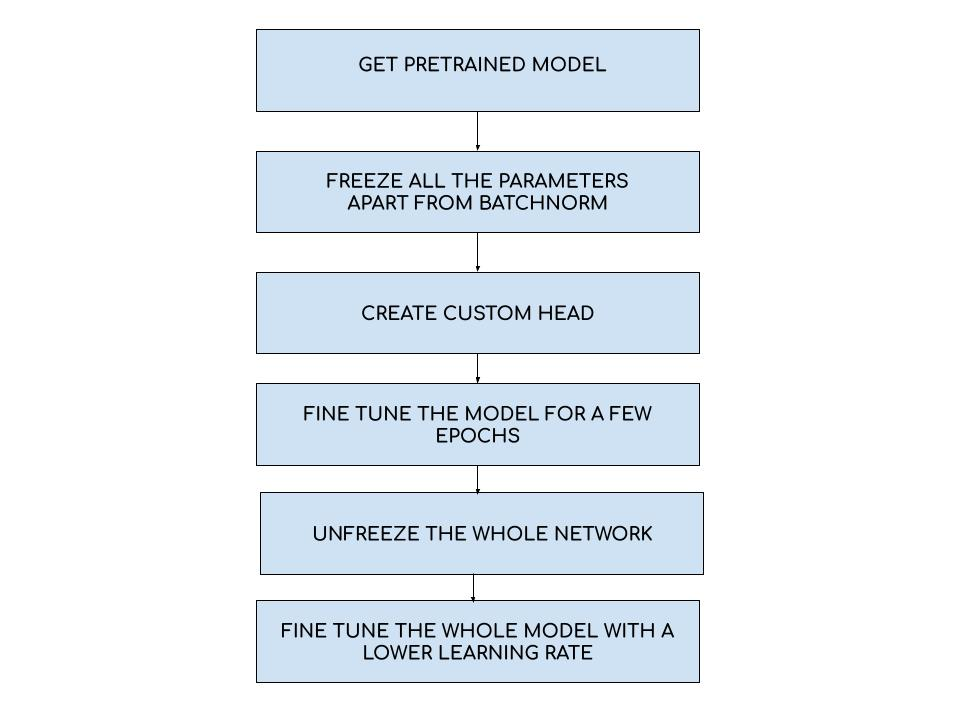

In [43]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='transfer learning with unfreezing'):
  config = wandb.config

  # create model
  model = create_model(config.architecture)
  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr, config.init_epochs)

  # Training while Frozen
  print('_'*40)
  print('Training with Frozen Body')
  print('_'*40)
  print()
  fit(config.init_epochs)

  # Unfreeze the model and train further
  print('_'*40)
  print('Unfreezing the body')
  print('_'*40)
  print()
  for param in model.parameters():
      param.requires_grad = True
  
  optimizer = get_optim(model, lr=1e-5)
  scheduler = get_scheduler(optimizer, 1e-5, config.num_epochs)

  print('_'*40)
  print('Training with Unfrozen Body')
  print('_'*40)
  print()
  fit(config.num_epochs)

________________________________________
Training with Frozen Body
________________________________________



Epoch: 1. Train       Loss: 1.833 | Accuracy: 0.493: 100%|██████████| 148/148 [00:37<00:00,  4.00it/s]
Epoch: 1. Validation  Loss: 0.345 | Accuracy: 0.897: 100%|██████████| 62/62 [00:10<00:00,  5.86it/s]


Epoch: 2. Train       Loss: 0.765 | Accuracy: 0.774: 100%|██████████| 148/148 [00:37<00:00,  3.98it/s]
Epoch: 2. Validation  Loss: 0.227 | Accuracy: 0.929: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch: 3. Train       Loss: 0.544 | Accuracy: 0.831: 100%|██████████| 148/148 [00:37<00:00,  3.91it/s]
Epoch: 3. Validation  Loss: 0.179 | Accuracy: 0.943: 100%|██████████| 62/62 [00:11<00:00,  5.64it/s]


Epoch: 4. Train       Loss: 0.439 | Accuracy: 0.862: 100%|██████████| 148/148 [00:37<00:00,  3.93it/s]
Epoch: 4. Validation  Loss: 0.168 | Accuracy: 0.949: 100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch: 5. Train       Loss: 0.446 | Accuracy: 0.866: 100%|██████████| 148/148 [00:38<00:00,  3.89it/s]
Epoch: 5. Validation  Loss: 0.148 | Accuracy: 0.954: 100%|██████████| 62/62 [00:11<00:00,  5.41it/s]



________________________________________
Unfreezing the body
________________________________________

________________________________________
Training with Unfrozen Body
________________________________________



Epoch: 1. Train       Loss: 0.417 | Accuracy: 0.867: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 1. Validation  Loss: 0.154 | Accuracy: 0.953: 100%|██████████| 62/62 [00:11<00:00,  5.56it/s]


Epoch: 2. Train       Loss: 0.409 | Accuracy: 0.866: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 2. Validation  Loss: 0.144 | Accuracy: 0.953: 100%|██████████| 62/62 [00:11<00:00,  5.64it/s]


Epoch: 3. Train       Loss: 0.387 | Accuracy: 0.876: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 3. Validation  Loss: 0.145 | Accuracy: 0.953: 100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch: 4. Train       Loss: 0.359 | Accuracy: 0.886: 100%|██████████| 148/148 [00:53<00:00,  2.75it/s]
Epoch: 4. Validation  Loss: 0.137 | Accuracy: 0.957: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch: 5. Train       Loss: 0.337 | Accuracy: 0.896: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 5. Validation  Loss: 0.129 | Accuracy: 0.960: 100%|██████████| 62/62 [00:11<00:00,  5.51it/s]


Epoch: 6. Train       Loss: 0.328 | Accuracy: 0.892: 100%|██████████| 148/148 [00:53<00:00,  2.75it/s]
Epoch: 6. Validation  Loss: 0.136 | Accuracy: 0.957: 100%|██████████| 62/62 [00:11<00:00,  5.63it/s]


Epoch: 7. Train       Loss: 0.311 | Accuracy: 0.900: 100%|██████████| 148/148 [00:53<00:00,  2.74it/s]
Epoch: 7. Validation  Loss: 0.126 | Accuracy: 0.960: 100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch: 8. Train       Loss: 0.312 | Accuracy: 0.899: 100%|██████████| 148/148 [00:53<00:00,  2.74it/s]
Epoch: 8. Validation  Loss: 0.124 | Accuracy: 0.960: 100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch: 9. Train       Loss: 0.298 | Accuracy: 0.904: 100%|██████████| 148/148 [00:53<00:00,  2.74it/s]
Epoch: 9. Validation  Loss: 0.129 | Accuracy: 0.959: 100%|██████████| 62/62 [00:11<00:00,  5.52it/s]


Epoch: 10. Train       Loss: 0.304 | Accuracy: 0.902: 100%|██████████| 148/148 [00:54<00:00,  2.71it/s]
Epoch: 10. Validation  Loss: 0.127 | Accuracy: 0.960: 100%|██████████| 62/62 [00:10<00:00,  5.72it/s]


Train Accuracy,▁▆▇▇▇▇▇████████
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Val Accuracy,▁▅▆▇▇▇▇▇███████
Val Loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Train Accuracy,0.90187
Train Loss,0.30449
Val Accuracy,0.96043
Val Loss,0.12706


Our metrics keep on improving with the changes. This means we are headed to the right direction.

But if we think about it, our body and our head are two very different group of layers. On one hand, we have a body that has important weights learned from its previous task that it was pretrained on. And on the other hand, we have a head that has been initialized randomly and has no important weights until we start fine-tuning it.

We do not want to change the weights of the body too much as they have already learned important features that generalize well to a lot of vision tasks, while at the same time we want to make our head useful to our current task. How do we achieve both of these conditions? Enters Discriminative Learning Rates.

## Discriminative Learning Rates

Discriminative Fine Tuning was introduced by Jeremy Howard et al. in the paper [Universal Language Model Fine-Tuning for Text Classification](https://paperswithcode.com/paper/universal-language-model-fine-tuning-for-text) or ULMFiT in short.

The main intuition is that: even after we unfreeze, we stil care a lot about the quality of the pretrained weights. The best learning rates for the pretrained parameters should not be as high as for the randomly added parameters because the pretrained weights have been trained for hundreds of epochs, on millions of images.

Therefore, after unfreezing our whole model, we are going to train the head and the body using two different learning rates.

A good rule of thumb is: the body learning rate should be `2.6` smaller than the head learning rate. Therefore, we are going to divide the head learning rate by `2.6` to get the body learning rate.

In [44]:
class MyModel(nn.Module):
  def __init__(self, body, head):
    super(MyModel, self).__init__()
    self.body = body
    self.head = head
  
  def forward(self, x):
    out = self.body(x)
    return self.head(out)

In [45]:
with wandb.init(project='Transfer-Learning-Pytorch', config=configs, 
                name='discriminative learning rates'):
  config = wandb.config

  # create model
  body = create_model(config.architecture)[0]
  head = create_model(config.architecture)[1]
  model = MyModel(body, head)

  model = model.to(config.device)
  wandb.watch(model, log="all")

  optimizer = get_optim(model, config.lr)
  scheduler = get_scheduler(optimizer, config.lr,config.init_epochs)

  # Training while Frozen
  print('_'*40)
  print('Training with Frozen Body')
  print('_'*40)
  print()
  fit(config.init_epochs)

  # Unfreeze the model and train further
  print('_'*40)
  print('Unfreezing the body')
  print('_'*40)
  print()
  for param in model.parameters():
      param.requires_grad = True
  

  # update the learning rates of each param group
  head_params = []
  body_params = []

  for name, param in model.body.named_parameters():
    body_params.append(param)

  for name, param in model.head.named_parameters():
    head_params.append(param)


  optimizer = optim.AdamW([{'params':body_params}, {'params':head_params}], 
                          lr=1e-5)
  scheduler = get_scheduler(optimizer, config.head_lr, config.num_epochs)
  optimizer.param_groups[0]['lr'] = config.body_lr
  optimizer.param_groups[1]['lr'] = config.head_lr

  # discriminative learning rates
  print('_'*40)
  print('Training with Unfrozen Body')
  print('_'*40)
  print()
  fit(config.num_epochs)

________________________________________
Training with Frozen Body
________________________________________



Epoch: 1. Train       Loss: 1.788 | Accuracy: 0.502: 100%|██████████| 148/148 [00:37<00:00,  3.92it/s]
Epoch: 1. Validation  Loss: 0.354 | Accuracy: 0.896: 100%|██████████| 62/62 [00:10<00:00,  5.75it/s]


Epoch: 2. Train       Loss: 0.708 | Accuracy: 0.783: 100%|██████████| 148/148 [00:36<00:00,  4.01it/s]
Epoch: 2. Validation  Loss: 0.226 | Accuracy: 0.928: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch: 3. Train       Loss: 0.532 | Accuracy: 0.838: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
Epoch: 3. Validation  Loss: 0.168 | Accuracy: 0.948: 100%|██████████| 62/62 [00:10<00:00,  5.69it/s]


Epoch: 4. Train       Loss: 0.455 | Accuracy: 0.855: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
Epoch: 4. Validation  Loss: 0.161 | Accuracy: 0.948: 100%|██████████| 62/62 [00:10<00:00,  5.73it/s]


Epoch: 5. Train       Loss: 0.411 | Accuracy: 0.869: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
Epoch: 5. Validation  Loss: 0.155 | Accuracy: 0.949: 100%|██████████| 62/62 [00:11<00:00,  5.27it/s]



________________________________________
Unfreezing the body
________________________________________

________________________________________
Training with Unfrozen Body
________________________________________



Epoch: 1. Train       Loss: 0.405 | Accuracy: 0.870: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 1. Validation  Loss: 0.152 | Accuracy: 0.952: 100%|██████████| 62/62 [00:10<00:00,  5.68it/s]


Epoch: 2. Train       Loss: 0.408 | Accuracy: 0.870: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 2. Validation  Loss: 0.140 | Accuracy: 0.954: 100%|██████████| 62/62 [00:10<00:00,  5.75it/s]


Epoch: 3. Train       Loss: 0.382 | Accuracy: 0.881: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 3. Validation  Loss: 0.137 | Accuracy: 0.957: 100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Epoch: 4. Train       Loss: 0.374 | Accuracy: 0.883: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 4. Validation  Loss: 0.132 | Accuracy: 0.959: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s]


Epoch: 5. Train       Loss: 0.336 | Accuracy: 0.891: 100%|██████████| 148/148 [00:54<00:00,  2.73it/s]
Epoch: 5. Validation  Loss: 0.128 | Accuracy: 0.960: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch: 6. Train       Loss: 0.318 | Accuracy: 0.899: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 6. Validation  Loss: 0.128 | Accuracy: 0.960: 100%|██████████| 62/62 [00:10<00:00,  5.71it/s]


Epoch: 7. Train       Loss: 0.313 | Accuracy: 0.904: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 7. Validation  Loss: 0.126 | Accuracy: 0.960: 100%|██████████| 62/62 [00:10<00:00,  5.77it/s]


Epoch: 8. Train       Loss: 0.300 | Accuracy: 0.907: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 8. Validation  Loss: 0.125 | Accuracy: 0.960: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch: 9. Train       Loss: 0.301 | Accuracy: 0.906: 100%|██████████| 148/148 [00:53<00:00,  2.76it/s]
Epoch: 9. Validation  Loss: 0.122 | Accuracy: 0.962: 100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Epoch: 10. Train       Loss: 0.317 | Accuracy: 0.899: 100%|██████████| 148/148 [00:54<00:00,  2.73it/s]
Epoch: 10. Validation  Loss: 0.125 | Accuracy: 0.960: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s]


Train Accuracy,▁▆▇▇▇▇▇████████
Train Loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁
Val Accuracy,▁▄▆▆▇▇▇▇███████
Val Loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Accuracy,0.89927
Train Loss,0.31676
Val Accuracy,0.95968
Val Loss,0.12464


That brings us to the end of this blog post. You have seen some tweaks that you can use to make transfer learning work for your particular task.

Here is a plot depicting how our specific changes impacted our accuracy.

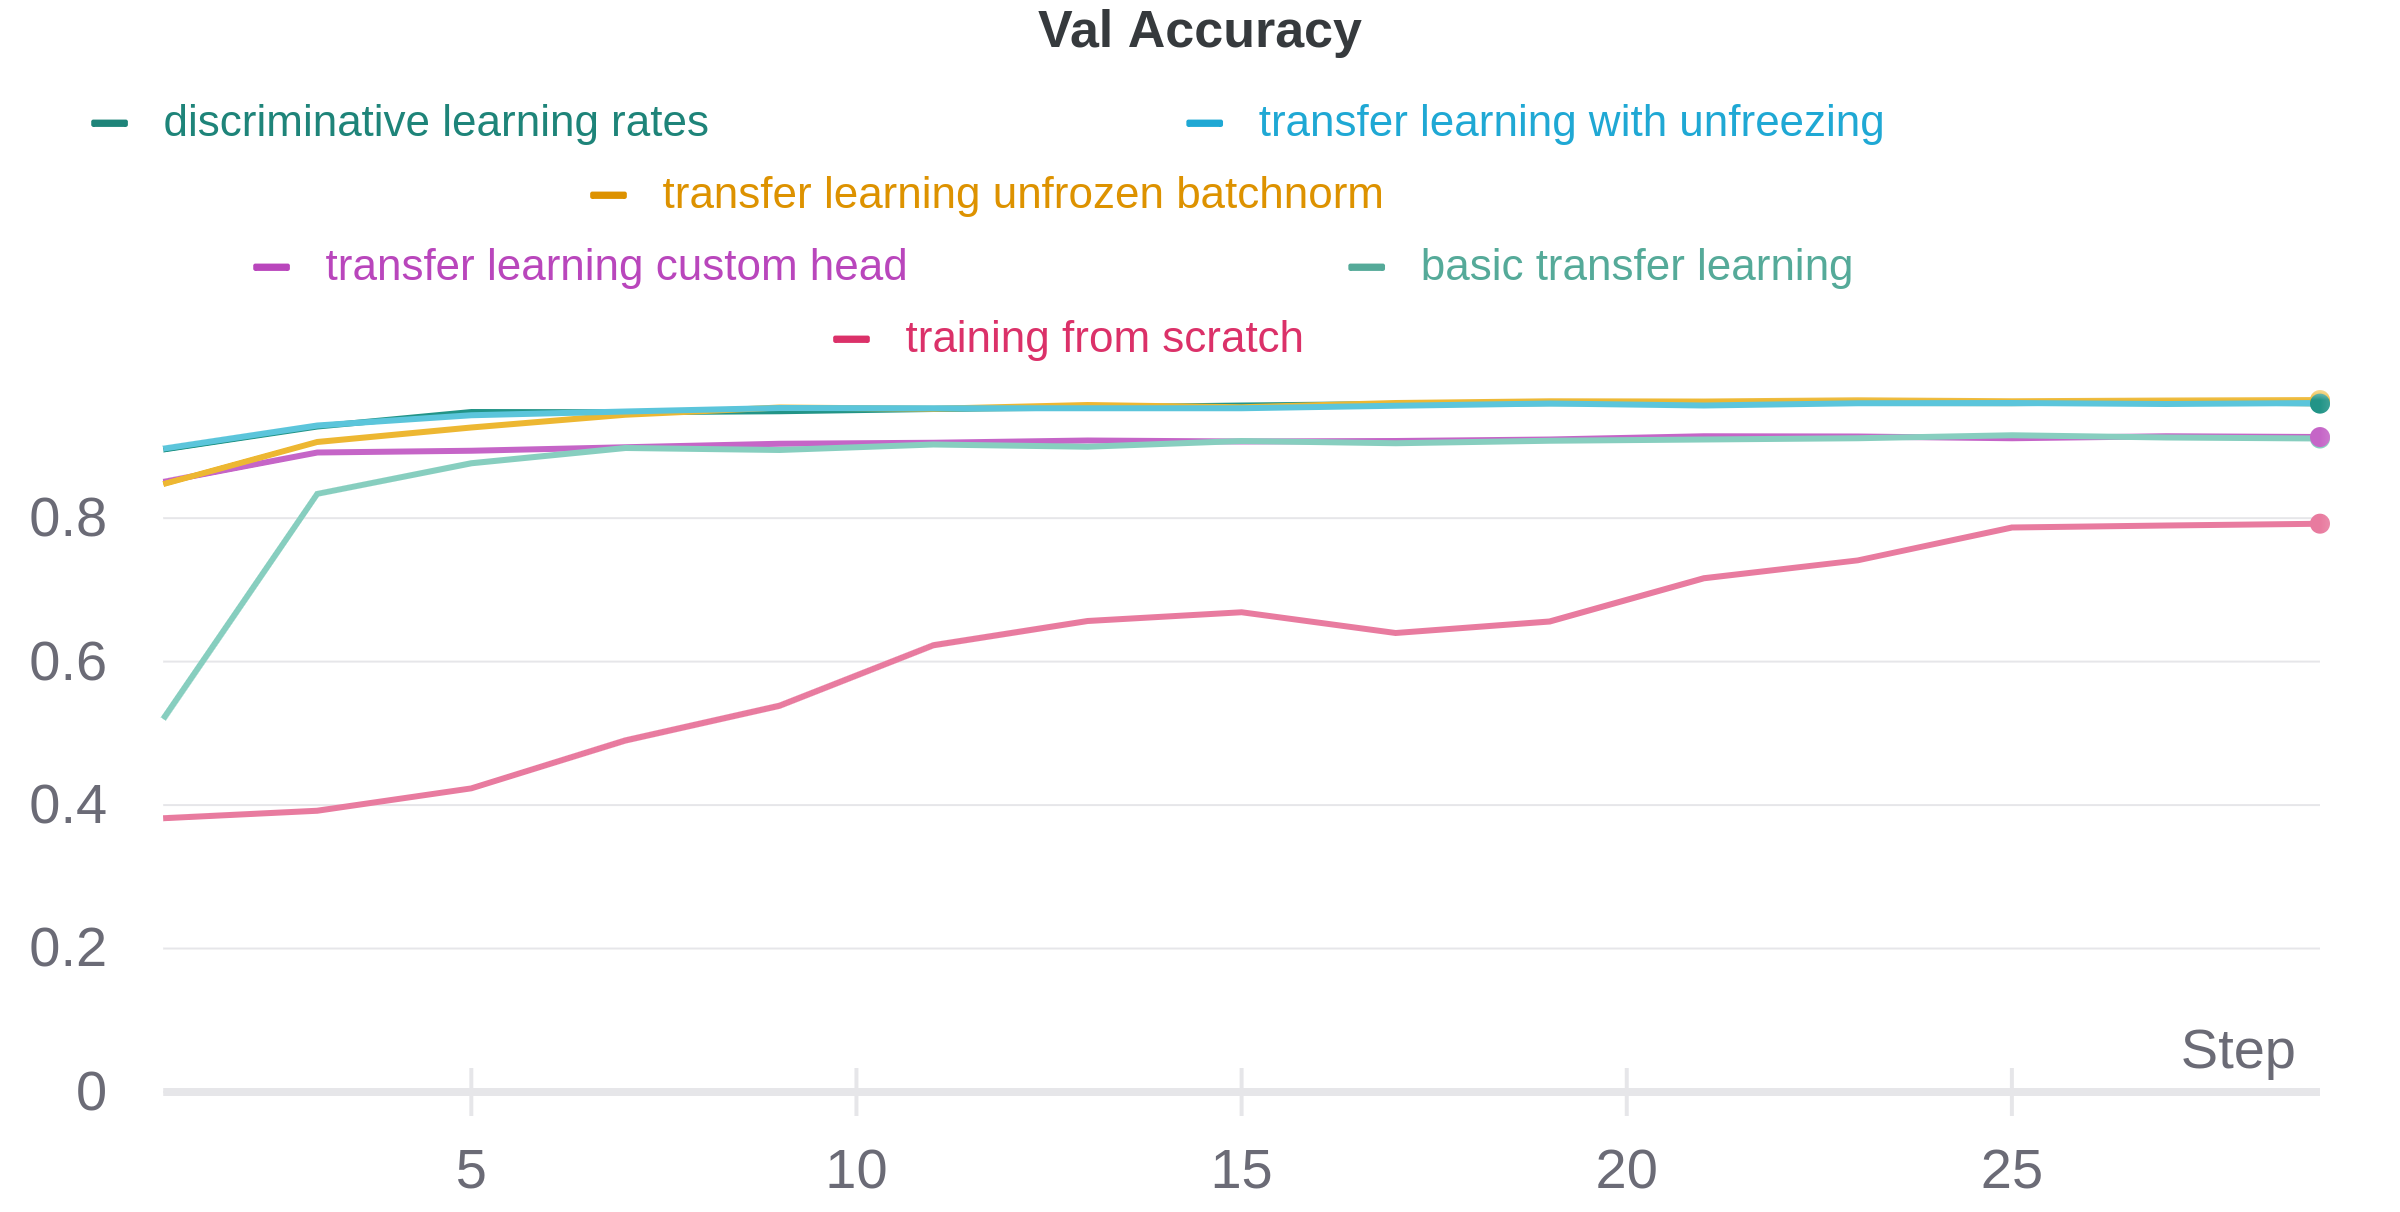

Follow me on [Twitter](https://twitter.com/jimmie_munyi) for more updates.